# Transparency Materials for ***Technology Diffusion, Human Capital and Employee Mobility***

----

**Updated:** *January 2026*

This notebook contains the code used for dataset construction, analysis and generating results tables for the paper. 

# Table of Contents
  - [1. Constructing Product Level Dataset](#1-constructing-product-level-dataset)
    - [1.1. Load Dataset](#11-load-dataset)
    - [1.2. Construct Variables to be Collapsed](#12-construct-variables-to-be-collapsed)
    - [1.3. Collapse Data Down to Project Level](#13-collapse-data-down-to-project-level)
  - [2.0. Individual Level Variable Construction](#20-individual-level-variable-construction)
    - [2.1. Construct Position Level Variables](#21-construct-position-level-variables)
    - [2.2. Construct Variables for Technology Diffusion and Mobility](#22-construct-variables-for-technology-diffusion-and-mobility)
  - [3.0. Results](#30-results)
    - [3.1. Baseline Regressions](#31-baseline-regressions)
    - [3.2. Results Stratified by Subsample of High-and-Low-Level Programmers & Creatives](#32-results-stratified-by-subsample-of-high-and-low-level-programmers--creatives)
    - [3.3. Regression Results with Alternative Measure of Popular Middleware](#33-regression-results-with-alternative-measure-of-popular-middleware)
    - [3.4. Regression Results with Share Based Measure of Product Diffusion](#34-regression-results-with-share-based-measure-of-product-diffusion)
    - [3.5. Regression Results for Cross Sectional Difference in Mobility after Technology Introduction](#35-regression-results-for-cross-sectional-difference-in-mobility-after-technology-introduction)
    - [3.6. Regression Results for Propability of Using Middleware (when moving between companies)](#36-regression-results-for-propability-of-using-middleware-when-moving-between-companies)
    - [3.7. Regression Results for Excluded Subsaple of Workers (i.e. Executives, Testers and others)](#37-regression-results-for-excluded-subsaple-of-workers-ie-executives-testers-and-others)
  - [4. Mobility Patterns over Time](#4-mobility-patterns-over-time)
    - [4.1. Coefficient Plot for Probability of Mobility with Popular Middleware Tools](#41-coefficient-plot-for-probability-of-mobility-with-popular-middleware-tools)
    - [4.2. Baseline Trends for Mobility Patterns between Programmers and Creatives](#42-baseline-trends-for-mobility-patterns-between-programmers-and-creatives)

In [1]:
// Preamble //
clear all
set more off
set linesize 255


## 1. Constructing Product Level Dataset
-----

In this Section of the notebook, we are loading the code at the product / project level and cleaning it. Mobility is based on movement between projects and therefore the use of middelware components, team size and product sales are all based on product level measures. Here we demonstrate the code used to generate those measures. 

### 1.1. Load Dataset 
----

Note, data is at the project (game) platform level and is therefore repeated for multiple platforms. To address this, we are constructing and cleaning variables at thh game level and then collapsing the data down to one observation per game.

In [2]:
*##############################################################################*
* LOAD MOBY GAMES DATASET 
*##############################################################################*

use "./Data/Project Level Data - MISQ - Middleware 2025.dta", clear

In [3]:
*##############################################################################*
* CLEAN UP RELEASE DATES 
*##############################################################################*

qui: gen release_date = reldate
qui: gen release_year = year(release_date)
qui: drop if release_year < 1990

qui: gen date = release_date - date("01Jan1990", "DMY")

*##############################################################################*
* REMOVE GAMES ON PC AND WINDOWS PLATFORMS 
*##############################################################################*

qui: decode(platform), generate(Ptfm)
qui: drop if Ptfm == "DOS" | Ptfm == "Windows" | Ptfm == "Windows 3.x" | Ptfm == "Commodore 64" | Ptfm == "PC Booter"

#### 1.2. Construct Variables to be Collapsed 
----

Here we construct indicator variables that represent each product. These will be collapsed down to the product level. There are often multiple rows per product because a single game may be availible on different platforms. This most impacts the platform indicators and the product sales variables which are different for each platform. The other columns are the same for all releases of a single title. 

In [4]:
// CREATE DUMMY VARIABLES FOR EACH PLATFORM //
qui: tabulate platform, generate(Ptfm_)

// IDENTIFY GAMES WHICH ARE IN THE SHOOTER GENRE //
qui: gen SHOOTER = (npd_supergenre == "SHOOTER")

// IDENTIFY GAMES THAT USE AT LEAST ONE MIDDLEWARE COMPONENT 
qui: egen MIDDLE = rmax(GameEngine_3rdparty GraphicsEngine_3rdparty ThreedEngine_3rdparty PhysicsEngine)
qui: egen INHOUSE = rmax(GameEngine_inhouse GraphicsEngine_inhouse ThreedEngine_inhouse)

// IDENTIFY DIFFERENT MIDDLEWARE COMPONENTS INCLUDING (MOST POPULAR) COMPONENTS//
qui: gen E_Graphics = "0.NONE" if GraphicsEngine_name1 == ""
qui: replace E_Graphics = "1.Less Popular" if GraphicsEngine_name1!="RenderWare" & GraphicsEngine_name1!=""
qui: replace E_Graphics = "2.Popular" if GraphicsEngine_name1=="RenderWare" 

qui: gen E_3D = "0.None" if ThreedEngine_name1 == ""
qui: replace E_3D = "1.Less Popular" if !regexm(ThreedEngine_name1, "Unreal") & ThreedEngine_name1!=""
qui: replace E_3D = "2.Popular" if regexm(ThreedEngine_name1, "Unreal") 

qui: gen E_Phys = "0.None" if PhysicsEngine_name1 == ""
qui: replace E_Phys = "1.Less Popular" if !regexm(PhysicsEngine_name1, "Havok") & PhysicsEngine_name1!=""
qui: replace E_Phys = "2.Popular" if regexm(PhysicsEngine_name1, "Havok") 

// IDENTIFY GAMES THAT USE AT LEAST ONE MAJOR | POPULAR MIDDLEWARE COMPONENT //
qui: gen PopularMiddleware = 1 if regexm(E_3D, "2.") | regexm(E_Graphics, "2.") | regexm(E_Phys, "2.")
qui: replace PopularMiddleware = 0 if PopularMiddleware == .

// BECAUSE RENDERWARE WAS NO LONGER THIRD PARTY AFTER BEING PURCHASED BY EA, WE ENSURE IT IS ALWAYS CONSIDERED THIRD PARTY //
qui: replace MIDDLE=1 if PopularMiddleware==1

#### 1.3. Collapse Data Down to Project Level 
-----

In [5]:
*##############################################################################*
* SORT THE DATA PRIOR TO COLLAPSING
* ---------------------------------------------------------------------------- *
* NOTE THAT SORTING IS DONE TO ENSURE THAT THE PLATFORMS ARE ALWAYS LISTED IN THE SAME ORDER 
* SUCH THAT THE STUDIO FOR A TITLE IS ALWAYS LISTED -- THIS IS IMPORTANT BECAUSE 
* DIFFERENT PLATFORMS MAY HAVE DIFFERENT DEVELOPERS (OR DEVELOPR NAMES)
* FOR THE SAME GAME, AND THIS ENSURES THAT THE FIRST OBSERVATION IS ALWAYS THE SAME.  
*##############################################################################*

gsort urlnew -npd_supergenre
qui: by urlnew: replace npd_supergenre=npd_supergenre[_n-1] if npd_supergenre[_n-1]!=""

sort urlnew release_date Ptfm MIDDLE

// COLLAPSE THE DATA TO ONE OBSERVATION PER GAME //
#delimit; 

collapse (firstnm) title publisher pub_corp dev_corp developer game_id npd_supergenre npd_genre E_* 
         (max) SHOOTER LicensedTitle inhouse PopularMiddleware* Ptfm_* MIDDLE INHOUSE   
         (sum) CumulativeSales 
         (min) release_date date release_year, 
         by(urlnew);

#delimit cr

// LOG TRANSFORM TOTAL SALES VARIABLE AFTER IT HAS BEEN AGGREGATED //
qui: gen logRevenue = ln(CumulativeSales)

In [6]:
save "./Data/project level data.dta", replace

file ./Data/project level data.dta saved


## 2.0. Individual Level Variable Construction  
----

Worker mobility is based on the individual level which contains information about each worker, their mobility between projects. In this stage, the two datasets are combined: Project Level Data which Contains Information about each title and middleware use & Individual Level data which contains information about each worker and their experience. 

In [7]:
*##############################################################################*
* LOAD PROJECT LEVEL DATA 
*###############################################################################*

use "./Data/project level data.dta", clear 

*##############################################################################*
* MERGE IN INDIVIDUAL LEVEL DATA 
*###############################################################################*

qui: joinby urlnew using "./Data/Individual Level Data - MISQ - Middleware 2025.dta"

*##############################################################################*
* MERGE IN SEX AND ETHNICITY DATA (FROM CLASSIFIER BASED ON INDIVIDUAL NAMES)
*###############################################################################*

qui: merge m:1 developer_id using "./Data/classified names.dta"

// CLEAN UP GENDER AND ETHNICITY DATA //
qui: replace gender = "unknown" if gender == "andy"
qui: replace gender = "female" if gender == "mostly_female"
qui: replace gender = "male" if gender == "mostly_male"

qui: egen GenderID = group(gender)

qui: gen ethnicity = race
qui: egen EthnicityID = group(ethnicity)

qui: drop gender ethnicity race 


### 2.1. Construct Position Level Variables 
-----

In [8]:
*##############################################################################*
* CLEAN UP INDIVIDUAL LEVEL DATA AND CONSTRUCT VARIABLES
*###############################################################################*

// REMOVE WORKERS FOR WHO WE DO NOT HAVE INFORMATION ABOUT WHEN THE TITLE WAS RELEASED //
qui: drop if missing(date)

// CONSTRUCT WORKER UNIQUE ID //
qui: egen ID = group(developer_id) 

In [9]:
*###############################################################################*
* CLEAN UP TEXTUAL DATA FOR VARIABLES 
*###############################################################################*

// CLEAN DOUBLE QUOTES WITHIN SOME ROLE NAMES
qui: replace ruo_role = strtrim(ruo_role)
qui: replace ruo_role = ustrregexra(ruo_role, `"[\"""]"', "")

// DEFINE WORKER ROLES //
qui: replace ruo_role = lower(ruo_role)

qui: gen Hierarchy = "5.Other"
qui: replace Hierarchy = "1.Executive" if regexm(ruo_role, "game director") | regexm(ruo_role, "producer|production")
qui: replace Hierarchy = "2.Programmer" if regexm(ruo_department, "Programming|Engineering") 
qui: replace Hierarchy = "3.Creative" if (regexm(ruo_department, "Design|Art|Graphics|Writers|Audio|Video")|regexm(ruo_role, "audio|sound|music")) | (regexm(ruo_role,"graphics") & Hierarchy !="2.Programmer") 
qui: replace Hierarchy = "4.Testers" if regexm(ruo_role, "tester")

qui: egen HID = group(Hierarchy)

// DISTINGUISH HIGH AND LOW LEVEL ROLES //
qui: gen lowlevelprogrammer=0
qui: replace lowlevelprogrammer =1 if HID == 2 & (strmatch(ruo_role,"*engine ")==1 | strmatch(ruo_role,"*tool*")==1 | strmatch(ruo_role,"*graphic*")==1 |strmatch(ruo_role,"*library*")==1 | strmatch(ruo_role,"*low level*")==1 | strmatch(ruo_role,"*optimiz*")==1 | strmatch(ruo_role,"*render*")==1 | strmatch(ruo_role,"*shader*")==1 | strmatch(ruo_role,"*r&d*")==1 | strmatch(ruo_role,"*r'n'd*")==1 | strmatch(ruo_role,"*system*")==1 | strmatch(ruo_role,"*physics*")==1 | strmatch(ruo_role,"*simulation*")==1 | strmatch(ruo_role,"*advanced techno*")==1 | strmatch(ruo_role,"*core techno*")==1 | strmatch(ruo_role,"*platform*")==1 | strmatch(ruo_role,"ps3*")==1 | strmatch(ruo_role,"*architect*")==1 | strmatch(ruo_role,"*conversion*")==1 | strmatch(ruo_role,"asura *")==1 | strmatch(ruo_role,"console*")==1 | strmatch(ruo_role,"converter*")==1 | strmatch(ruo_role,"*framework*")==1 | strmatch(ruo_role,"ngl *")==1 | strmatch(ruo_role,"*architect*")==1 | strmatch(ruo_role,"xbox *")==1 | strmatch(ruo_role,"x360 *")==1 | strmatch(ruo_role,"xbox360 *")==1 | strmatch(ruo_role,"*abstraction*")==1 | strmatch(ruo_role,"dreamcast *")==1 | strmatch(ruo_role,"lithtech *")==1 | strmatch(ruo_role,"gamecube *")==1 | strmatch(ruo_role,"playstation*")==1 | strmatch(ruo_role,"ps2*")==1 | strmatch(ruo_role,"ps3*")==1 | strmatch(ruo_role,"psx*")==1 | strmatch(ruo_role,"multiplatform*")==1 | strmatch(ruo_role,"multi-platform*")==1 | strmatch(ruo_role,"*microcode*")==1 | strmatch(ruo_role,"vu *")==1 | strmatch(ruo_role,"vu1 *")==1 | strmatch(ruo_role,"*dynamics*")==1)
qui: replace lowlevelprogrammer =1 if HID == 2 & (regexm(ruo_department, "Technology") & regexm(ruo_role,"tools|technology|technical|technologies|control tech|technologist|tech|central technology|digital engineer|r&d|r & d|research and development|engine|abstraction")) & regexm(ruo_role,"online|web|information")==0
qui: replace lowlevelprogrammer = 1 if strmatch(ruo_role, "system engineer") | strmatch(ruo_role, "technology group director") | strmatch(ruo_role, "technical coordinators") | strmatch(ruo_role, "integration engineers") | strmatch(ruo_role, "integration engineering team") | strmatch(ruo_role, "effect programmers") | strmatch(ruo_role, "effect programmer") | strmatch(ruo_role, "yeti engine") | strmatch(ruo_role, "game engine team") | strmatch(ruo_role, "technology director") | strmatch(ruo_role, "character technical director") | strmatch(ruo_role, "effect program") | strmatch(ruo_role, "senior standards technicians") | strmatch(ruo_role, "technical leads") | strmatch(ruo_role, "mechanical engineer") | strmatch(ruo_role, "technology team") | strmatch(ruo_role, "pure 3d") | strmatch(ruo_role, "technical team") | strmatch(ruo_role, "floor leads, technical requirements group") | strmatch(ruo_role, "pure3d") | strmatch(ruo_role, "engine") | strmatch(ruo_role, "additional engine programming") | strmatch(ruo_role, "technical engineers") | strmatch(ruo_role, "integration") | strmatch(ruo_role, "technology programmers") | strmatch(ruo_role, "technical board") | strmatch(ruo_role, "integrators") | strmatch(ruo_role, "technical dept.") | strmatch(ruo_role, "technical standard analysts") | strmatch(ruo_role, "technology programming team") | strmatch(ruo_role, "technology group") | strmatch(ruo_role, "technical standards analyst") | strmatch(ruo_role, "technical supervisor") | strmatch(ruo_role, "3d engine") | strmatch(ruo_role, "frostbite engine team") | strmatch(ruo_role, "hardware engineer") | strmatch(ruo_role, "engine technology") | strmatch(ruo_role, "central technology") | strmatch(ruo_role, "engine programmer") | strmatch(ruo_role, "infrastructure") | strmatch(ruo_role, "technology programming") | strmatch(ruo_role, "senior engine programmers") | strmatch(ruo_role, "libraries / utilities") | strmatch(ruo_role, "lead engine programmer") | strmatch(ruo_role, "technical direction") | strmatch(ruo_role, "technical producer") | strmatch(ruo_role, "engine team") | strmatch(ruo_role, "3d programmers") | strmatch(ruo_role, "technical lead") | strmatch(ruo_role, "technology") | strmatch(ruo_role, "director of technology") | strmatch(ruo_role, "technical standards analysts") | strmatch(ruo_role, "technical directors") | strmatch(ruo_role, "engine programming") | strmatch(ruo_role, "engine programmers")
qui: replace lowlevelprogrammer = 0 if (regexm(ruo_role, "engineer")==1 & regexm(ruo_role, "tool|systems|r&d|library|platform|lithtech|ps2|physics|[[:<:]]engine[[:>:]]|digital")==0)

qui: gen lowlevelcreative=0
qui: replace lowlevelcreative = 1 if HID == 3 & (strmatch(ruo_role,"*sound engineer*") | strmatch(ruo_role,"*foley engineer*") | strmatch(ruo_role,"*sound design*") | strmatch(ruo_role,"*sound mixer*") | strmatch(ruo_role,"*sound system*") | strmatch(ruo_role,"*sound. tools*") | strmatch(ruo_role,"*video engineer*") | strmatch(ruo_role,"*video capture*") | strmatch(ruo_role,"*video compression*") | strmatch(ruo_role,"*video conversion*") | strmatch(ruo_role,"*post fx*") | strmatch(ruo_role,"*post-fx*") | strmatch(ruo_role,"*post production*") | strmatch(ruo_role,"*post-production*") | strmatch(ruo_role,"*post-processing*") | strmatch(ruo_role,"*remastering*") | strmatch(ruo_role,"*re-master*") | strmatch(ruo_role,"*encoding*") | strmatch(ruo_role,"*mastering*") | strmatch(ruo_role,"*movie audio editing*") | strmatch(ruo_role,"*newscuts*") | strmatch(ruo_role,"*protools*") | strmatch(ruo_role,"*vfx*") | strmatch(ruo_role,"*visual effect*") | strmatch(ruo_role,"*visual fx*") | strmatch(ruo_role,"*special effects*") | strmatch(ruo_role,"*effects*") | strmatch(ruo_role,"*effect animator*") | strmatch(ruo_role,"*effect animation*") | strmatch(ruo_role,"*effect design*") | strmatch(ruo_role,"*efx*") | strmatch(ruo_role,"*fx programmer*") | strmatch(ruo_role,"*fx cg*") | strmatch(ruo_role,"*scanner*") | strmatch(ruo_role,"*scanning*") | strmatch(ruo_role,"*capture*") | strmatch(ruo_role,"*mocap*") | strmatch(ruo_role,"*mo cap*") | strmatch(ruo_role,"*mo-cap*") | strmatch(ruo_role,"*motion capture*") | strmatch(ruo_role,"*facial capture*") | strmatch(ruo_role,"*game capture*") | strmatch(ruo_role,"*texture*") | strmatch(ruo_role,"*textur*") | strmatch(ruo_role,"*shader*") | strmatch(ruo_role,"*shading*") | strmatch(ruo_role,"*shade*") | strmatch(ruo_role,"*render*") | strmatch(ruo_role,"*renders*") | strmatch(ruo_role,"*graphics engineering*") | strmatch(ruo_role,"*graphics system*") | strmatch(ruo_role,"*graphic concepts*") | strmatch(ruo_role,"*graphical enhancer*") | strmatch(ruo_role,"*game graphics*") | strmatch(ruo_role,"*height map*") | strmatch(ruo_role,"*shadow*") | strmatch(ruo_role,"*user interface*") | strmatch(ruo_role,"*interface*") | strmatch(ruo_role,"*ui*") | strmatch(ruo_role,"*user experience*") | strmatch(ruo_role,"*ux*") | strmatch(ruo_role,"*front end*") | strmatch(ruo_role,"*front-end*") | strmatch(ruo_role,"*hud*") | strmatch(ruo_role,"*compositing*") | strmatch(ruo_role,"*compositor*") | strmatch(ruo_role,"*composit*") | strmatch(ruo_role,"*layout*") | strmatch(ruo_role,"*assembly*") | strmatch(ruo_role,"*interior assembly*") | strmatch(ruo_role,"*level assembly*") | strmatch(ruo_role,"*breakable models*") | strmatch(ruo_role,"*pipeline*") | strmatch(ruo_role,"*framework*") | strmatch(ruo_role,"*framing*") | strmatch(ruo_role,"*scripting*") | strmatch(ruo_role,"*script coder*") | strmatch(ruo_role,"*scriptor*") | strmatch(ruo_role,"*scripter*") | strmatch(ruo_role,"*sdk*") | strmatch(ruo_role,"*code*") | strmatch(ruo_role,"*program*") | strmatch(ruo_role,"*software design*") | strmatch(ruo_role,"*software*") | strmatch(ruo_role,"*implementation*") | strmatch(ruo_role,"*technical*") | strmatch(ruo_role,"*technology*") | strmatch(ruo_role,"*tech*") | strmatch(ruo_role,"*techs*") | strmatch(ruo_role,"*setup*") | strmatch(ruo_role,"*set-up*") | strmatch(ruo_role,"*set up*") | strmatch(ruo_role,"*tools*") | strmatch(ruo_role,"*tool*") | strmatch(ruo_role,"*convert*") | strmatch(ruo_role,"*conversion*") | strmatch(ruo_role,"*process*") | strmatch(ruo_role,"*library*") | strmatch(ruo_role,"*art td*") | strmatch(ruo_role,"*character td*") | strmatch(ruo_role,"*wrangler*") | strmatch(ruo_role,"*integrat*") | strmatch(ruo_role,"*research*") | strmatch(ruo_role,"*rigger*") | strmatch(ruo_role,"*rigging*") | strmatch(ruo_role,"*tweaker*") | strmatch(ruo_role,"*lighting*") | strmatch(ruo_role,"*fx*") | strmatch(ruo_role,"*mesh*") | strmatch(ruo_role,"*event editor*") | strmatch(ruo_role,"*object engineer*") | strmatch(ruo_role,"*control system*") | strmatch(ruo_role,"*dynamics*") | strmatch(ruo_role,"*game logic*") | strmatch(ruo_role,"*game shell*") | strmatch(ruo_role,"*in-game camera*") | strmatch(ruo_role,"*modeler*") | strmatch(ruo_role,"*model er*") | strmatch(ruo_role,"*modeling*") | strmatch(ruo_role,"*maya operator*") | strmatch(ruo_role,"*mdel production*") | strmatch(ruo_role,"*motion programmer*") | strmatch(ruo_role,"*motion editor*") | strmatch(ruo_role,"*motion simulation*") | strmatch(ruo_role,"*interactive music programming*") | strmatch(ruo_role,"*music logic*") | strmatch(ruo_role,"*synchronization*"))

### 2.2. Construct Variables for Technology Diffusion and Mobility 
----

In [10]:
// CONSTRUCT COUNTER OF JOB NUMBER //

gsort ID date urlnew -HID -lowlevelprogrammer -lowlevelcreative
qui: egen id_urlnew_tag=tag(ID urlnew)
qui: drop if id_urlnew_tag==0
qui: by ID: gen JobN=sum(id_urlnew_tag)

// CONTRUCT MOBILITY VARIABLE (CHANGING BETWEEN DEVELOPER COMPANIES) //
gsort ID date urlnew
qui: by ID: gen DevChange = 1 if developer[_n] != developer[_n-1]
qui: replace DevChange = 0 if DevChange == .
qui: replace DevChange = . if JobN == 1
qui: replace DevChange = . if id_urlnew_tag==0

// CONTRUCT VARIABLE INDICATING WHEN BOTH COMPANIES USE MIDDLEWARE //
gsort ID date urlnew
qui: by ID:  gen MiddlewareChange = 1 if MIDDLE[_n] != MIDDLE[_n-1]
qui: replace MiddlewareChange = 0 if MiddlewareChange == .
qui: replace MiddlewareChange = . if JobN == 1

gsort ID date urlnew
qui: by ID: gen NonMiddlewareToMiddleware = 1 if MIDDLE[_n] ==1 & MIDDLE[_n-1] != 1
qui: replace NonMiddlewareToMiddleware = 0 if NonMiddlewareToMiddleware == .
qui: replace NonMiddlewareToMiddleware = . if JobN == 1

gsort ID date urlnew
qui: by ID:  gen MIDDLEP = MIDDLE[_n-1]

// IDENTIFY ROLE IN PREVIOUS JOB // 
gsort ID date urlnew
qui: by ID: gen HID_Previous = HID[_n-1] if _n > 1
qui: replace HID_Previous = . if HID_Previous == 0

// CONSTRUCT CONTROLS FOR INDIVIDUAL EXPERIENCE //
sort ID JobN
qui: by ID: gen MiddlewareExp = sum(MIDDLE)

// CONSTRUCT VARIABLES THAT CAPTURE FIRST AND LAST PRODUCTS DEVELOPER HAS RELEASED // 

* Publisher Level *
sort publisher urlnew ID
qui: by publisher urlnew: gen temp = 1 if _n == 1
qui: by publisher: gen RunningNPubTitles = sum(temp)
qui: by publisher: egen TotalNPubTitles = sum(temp)

qui: gen FirstPublisherRelease = 1 if RunningNPubTitles == 1
qui: replace FirstPublisherRelease = 0 if FirstPublisherRelease == .
qui: gen FinalPublisherRelease = 1 if RunningNPubTitles == TotalNPubTitles
qui: replace FinalPublisherRelease = 0 if FinalPublisherRelease == .
qui: drop temp

* Developer Level *
sort developer urlnew developer_id
qui: by developer urlnew:  gen temp = 1 if _n == 1
qui: by developer: gen RunningNDevTitles = sum(temp)
qui: by developer: egen MaxDevNTitles = sum(temp)
qui: drop temp

qui: gen FirstDeveloperRelease = 1 if RunningNDevTitles == 1
qui: replace FirstDeveloperRelease = 0 if FirstDeveloperRelease == .
qui: gen LastDeveloperRelease = 1 if RunningNDevTitles == MaxDevNTitles
qui: replace LastDeveloperRelease = 0 if LastDeveloperRelease == .

// CONSTRUCT VARIABLES FOR PROJECT SIZE AND IDENTIFIER PER TITLE //
sort urlnew date
qui: bysort urlnew: gen ProjectSize = _N
qui: bysort urlnew: gen ProjectIdentifier = 1 if _n == 1

// CONSTRUCT INDICATOR VARIABLE FOR PERIOD AFTER 2002 (WHEN MIDDLEWARE BECAME MORE COMMON) //
qui: gen Post2002 = 1 if release_year >= 2002
qui: replace Post2002 = 0 if Post2002 == .

// CONSTRUCT VARIABLE FOR DIFFUSION OF MIDDLEWARE WITHIN GENRE //
gsort urlnew -npd_supergenre
*qui: by urlnew: replace npd_supergenre=npd_supergenre[_n-1] if npd_supergenre[_n-1]!=""
qui: bysort SHOOTER release_year: egen temp_0 = mean(MIDDLE) if ProjectIdentifier == 1
qui: bysort SHOOTER release_year: egen ShareMiddleware = max(temp_0)

// EXPERIENCE WITH COMPANY //
sort ID developer JobN
qui: by ID developer: gen N_Projects_Dev = _n - 1

In [11]:
// CREATE NEW VARIABLES WITH NAMES MORE EASY TO USE IN REGRESSION //

qui: gen Creative = 1 if HID == 3
qui: replace Creative = 0 if HID == 2

qui: gen Role = "Creative" if HID == 3
qui: replace Role = "Programmer" if HID == 2

qui: gen POST = Post2002
qui: gen PopMIDDLE = PopularMiddleware
qui: gen ShareMIDDLE = ShareMiddleware

## 3.0. Results 
----

Here we report the regression results for the paper.

### 3.1. Baseline Regressions 

----

In [ ]:
*##############################################################################*
* ESTIMATE BASELINE REGRESSIONS 
* ---------------------------------------------------------------------------- *
* We estimate the following models for our analysis
* 1. Full Sample (Individual Coefficients for Post, Middle & Shooter)
* 2. Full Sample (Individual Interactions Included)
* 3. (## IN PAPER: TABLE 1, COLUMN 1 ##) Full Sample (Interactions Included & Publisher Level FEs)
* 4. Full Sample (Interactions Included & Longer Time Window (Developer, Gender & Ethnicity FEs + Publisher FEs))
* 5. (## IN PAPER: TABLE 1, COLUMN 3 ##) Sample of Creatives (Interactions, Controls and Developer, Gender & Ethnicity FEs)
* 6. (## IN PAPER: TABLE 1, COLUMN 2 ##) Sample of Programmers (Interactions, Controls and Developer, Gender & Ethnicity FEs) 
*##############################################################################*

*# Define Variables in Macros #*

local FEs " developer GenderID EthnicityID "
local Controls "i.Creative JobN logRevenue ProjectSize Ptfm_* i.release_year MiddlewareExp "
local time_window " release_year >= 1995 & release_year <= 2005"
local Constraints "FinalPublisherRelease != 1 & FirstPublisherRelease != 1 & LastDeveloperRelease != 1 & (HID == 3| HID == 2) & (HID == HID_Previous)"

*# 1. Full Sample - Baseline Coefficients #* 
qui: reghdfe DevChange i.SHOOTER i.POST i.MIDDLE i.Creative `Controls' if `Constraints' & `time_window', absorb(`FEs')
est store R_BL_1

*# 2. Full Sample - Baseline Coefficients & Interactions #* 
qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE `Controls' if `Constraints' & `time_window', absorb(`FEs')
est store R_BL_2

*# 3. Full Sample - Add Publisher Level Firm Level FE's #*
qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE i.Creative `Controls' if `Constraints' & `time_window', absorb(`FEs' pub_corp)
est store R_BL_3

*# 4. Full Sample - Extend Time Window #*
local time_window " release_year >= 1995 & release_year <= 2008"
qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE i.Creative `Controls' if `Constraints' & `time_window', absorb(`FEs')
est store R_BL_4

*# 5. Creatives #*
local time_window " release_year >= 1995 & release_year <= 2005"
qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE i.Creative `Controls' if `Constraints' & Role == "Creative" & `time_window', absorb(`FEs')
est store R_BL_5a

*# 6. Programmers #*
qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE i.Creative `Controls' if `Constraints' & Role == "Programmer" & `time_window', absorb(`FEs')
est store R_BL_5b

*##############################################################################*
* Output Regression Results
*##############################################################################*

#delimit; 
esttab R_BL_* , 
noomitted nobase 
b(%4.3f) se(%4.3f) 
scalars(r2 F p )
varwidth(35)
mtitles("BL" "BL" "Pub Corp FE" "Ext. Time Window" "Creatives" "Programmers")
indicate("Project Size and Sales = logRevenue ProjectSize" 
         "Year FE = *release_year " 
         "Ptfm FE = *Ptfm*"
         "Experience Controls = MiddlewareExp JobN", labels("Y" ""));
#delimit cr



-----------------------------------------------------------------------------------------------------------------------------------
                                             (1)             (2)             (3)             (4)             (5)             (6)   
                                              BL              BL     Pub Corp FE    Ext. Time ~w       Creatives     Programmers   
-----------------------------------------------------------------------------------------------------------------------------------
1.SHOOTER                                  0.035**        -0.034*         -0.046**        -0.046**        -0.021          -0.049   
                                         (0.011)         (0.015)         (0.016)         (0.015)         (0.018)         (0.028)   

1.POST                                    -0.076**        -0.092***       -0.092***       -0.106***       -0.070*         -0.190***
                                         (0.024)         (0.024)         (

(file Margins Plot - Likelihood of Changing Employer by Genre and Middleware (Full Sample).png not found)
file Margins Plot - Likelihood of Changing Employer by Genre and Middleware (Full Sample).png written in PNG format
(file Margins Plot - Likelihood of Changing Employer by Genre and Middleware (Programmers and Creatives).png not found)
file Margins Plot - Likelihood of Changing Employer by Genre and Middleware (Programmers and Creatives).png written in PNG format


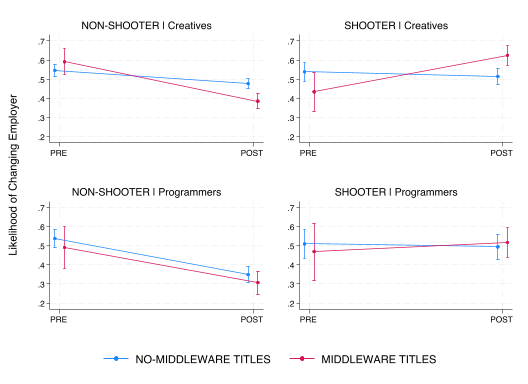

In [ ]:
*##############################################################################*
* CREATE MARGINAL EFFECTS PLOTS                                                *
* ---------------------------------------------------------------------------- *
* To do this, we recreate the baseline results (TABLE 1: COLUMNS 1, 2, & 3).
* We then compute marginal effects for Shooter & Non Shooter categories so 
* that we can easily plot them on the same graph. 
* We estimate first for the full sample, and then creatives and programmers 
* respectivley. 
*##############################################################################*

local FEs " developer GenderID EthnicityID "
local Controls "i.Creative JobN logRevenue ProjectSize Ptfm_* i.release_year MiddlewareExp "
local Min "1995"
local Max "2005"
local Constraints "FinalPublisherRelease != 1 & FirstPublisherRelease != 1 & LastDeveloperRelease != 1 & (HID == 3| HID == 2) & (HID == HID_Previous) & release_year >= `Min' & release_year <= `Max' "

*# TABLE 1 - Column 1: Full Sample ###################################################################*

qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE `Controls' if `Constraints' , absorb(`FEs')

qui: margins MIDDLE if SHOOTER == 1 , at(POST =(0(1)1)) noestimcheck
qui: mplotoffset,  title("SHOOTER") xlabel( 0 "PRE " 1 "POST ") xtitle("") ytitle("") legend(order(3 "NO-MIDDLEWARE TITLES" 4 "MIDDLEWARE TITLES") region(lcolor(none)) cols(2) ) name(m__A, replace) nodraw

qui: margins MIDDLE if SHOOTER == 0 , at(POST =(0(1)1)) noestimcheck 
qui: mplotoffset,  title("NON-SHOOTER") xlabel( 0 "PRE " 1 "POST ") xtitle("") ytitle("") legend(order(3 "NO-MIDDLEWARE TITLES" 4 "MIDDLEWARE TITLES") region(lcolor(none)) cols(2)) name(m__B, replace ) nodraw

*# TABLE 1 - Column 2: PROGRAMMERS ###################################################################*

qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE  `Controls' if `Constraints' & Role == "Programmer", absorb(`FEs')

qui: margins MIDDLE if SHOOTER == 1 , at(POST =(0(1)1)) noestimcheck
qui: mplotoffset,  title("SHOOTER | Programmers") xlabel( 0 "PRE " 1 "POST ") xtitle("") ytitle("") legend(order(3 "NO-MIDDLEWARE TITLES" 4 "MIDDLEWARE TITLES") region(lcolor(none)) cols(2)) name(m__3, replace) nodraw

qui: margins MIDDLE if SHOOTER == 0 , at(POST =(0(1)1)) noestimcheck 
qui: mplotoffset,  title("NON-SHOOTER | Programmers") xlabel( 0 "PRE " 1 "POST ") xtitle("") ytitle("") legend(order(3 "NO-MIDDLEWARE TITLES" 4 "MIDDLEWARE TITLES") region(lcolor(none)) cols(2)) name(m__4, replace) nodraw

*# TABLE 1 - Column 3: CREATIVES ###################################################################*

qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE `Controls' if `Constraints' & Role == "Creative", absorb(`FEs')

qui: margins MIDDLE if SHOOTER == 1 , at(POST =(0(1)1)) noestimcheck
qui: mplotoffset,  title("SHOOTER | Creatives") xlabel( 0 "PRE " 1 "POST ") xtitle("") ytitle("") legend(order(3 "NO-MIDDLEWARE TITLES" 4 "MIDDLEWARE TITLES") region(lcolor(none)) cols(2) ) name(m__1, replace) nodraw

qui: margins MIDDLE if SHOOTER == 0 , at(POST =(0(1)1)) noestimcheck 
qui: mplotoffset,  title("NON-SHOOTER | Creatives") xlabel( 0 "PRE " 1 "POST ") xtitle("") ytitle("") legend(order(3 "NO-MIDDLEWARE TITLES" 4 "MIDDLEWARE TITLES") region(lcolor(none)) cols(2)) name(m__2, replace ) nodraw

*# Compile Figure for Baseline Results #*

grc1leg m__B m__A , col(2) ycommon l2title("Likelihood of Changing Employer") name(grc1leg, replace)
graph export "./Figures & Tables/Margins Plot - Likelihood of Changing Employer by Genre and Middleware (Full Sample).png", replace

*# Compile Figure for Programmers & Creatives #*

grc1leg m__2 m__1 m__4 m__3, col(2) ycommon l2title("Likelihood of Changing Employer") name(grc1leg, replace)
graph export "./Figures and Tables/Margins Plot - Likelihood of Changing Employer by Genre and Middleware (Programmers and Creatives).png", replace

### 3.2. Results Stratified by Subsample of High-and-Low-Level Programmers & Creatives
----

In [ ]:
*##############################################################################*
* ESTIMATE RESULTS FOR HIGH AND LOW TYPES OF DEVELOPERS                        *
* ---------------------------------------------------------------------------- *
* Above we defined "high level creative" and "low level programmer" based on 
* role information, to futher distinguish those who were involved in tasks 
* complementary to these middleware technologies and those being substiituted. 
* Low level programmers are those who are involved in developing core game 
* functionality, while high level creatives are the ones who are involved in 
* using these middleware tools. 
*
* The results estiamted are:
* 1. (## IN PAPER: TABLE 1, COLUMN 5 ##) Sample of High Level Creatives
* 2. Sample of Low Level Creatives 
* 3. Sample of High Level Programmers 
* 4. (## IN PAPER: TABLE 1, COLUMN 4 ##) Sample of Low Level Programmers 
*##############################################################################*

*# Define Variables #*

local FEs " developer GenderID EthnicityID "
local Controls "i.Creative JobN logRevenue ProjectSize Ptfm_* i.release_year MiddlewareExp "
local Min "1995"
local Max "2005"
local Constraints "FinalPublisherRelease != 1 & FirstPublisherRelease != 1 & LastDeveloperRelease != 1 & (HID == 3| HID == 2) & (HID == HID_Previous) & release_year >= `Min' & release_year <= `Max' "

*# 1. High Level Creatives #*
qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE `Controls'  if `Constraints' & lowlevelcreative == 1 & (HID == 3), absorb(`FEs')
est store R_HLC_a

*# 2. Low Level Creatives #*
qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE `Controls'  if `Constraints' & lowlevelcreative == 0 & (HID == 3), absorb(`FEs')
est store R_HLC_b

*# 3. High Level Programmers #*
qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE `Controls'  if `Constraints' & lowlevelprogrammer == 1 & (HID == 2), absorb(`FEs')
est store R_HLP_a

*# 4. Low Level Programmers #*
qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE `Controls'  if `Constraints' & lowlevelprogrammer == 0 & (HID == 2), absorb(`FEs')
est store R_HLP_b

*##############################################################################*
* Output Regression Results
*##############################################################################*

#delimit; 
esttab R_HLC* R_HLP*, 
noomitted nobase 
b(%4.3f) se(%4.3f) 
scalars(r2 F p )
varwidth(35)
mtitles("L Creatives" "H Creatives" "L Programmers" "H Programmers")
indicate("Project Size and Sales = logRevenue ProjectSize" 
         "Year FE = *release_year " 
         "Ptfm FE = *Ptfm*"
         "Experience Controls = MiddlewareExp JobN", labels("Y" ""));
#delimit cr 



---------------------------------------------------------------------------------------------------
                                             (1)             (2)             (3)             (4)   
                                     L Creatives     H Creatives    L Programm~s    H Programm~s   
---------------------------------------------------------------------------------------------------
1.SHOOTER                                 -0.158**        -0.007          -0.185*         -0.029   
                                         (0.056)         (0.019)         (0.090)         (0.030)   

1.POST                                    -0.122          -0.067*         -0.448**        -0.113*  
                                         (0.117)         (0.031)         (0.146)         (0.049)   

1.SHOOTER#1.POST                           0.183*          0.035           0.412***        0.145***
                                         (0.075)         (0.028)         (0.124)         (0.043) 

### 3.3. Regression Results with Alternative Measure of Popular Middleware
---- 


In [ ]:
*##############################################################################*
* ESTIMATE RESULTS WITH POPULAR MIDDLEWARE TOOLS                               *
* ---------------------------------------------------------------------------- *
* Above the variable MIDDLE defined major middleware tools. However, only a 
* small number of these tools (e.g. Havok) were commonly used across many firms.
* Here we use the redefined variables (PopMIDDLE) for Popular Middleware tools
* and re-estimate our results. 
* 
* The results estiamted are:
* 1. (## IN PAPER: TABLE 2, COLUMN 1 ##) Full Sample of Creatives and Programmers
* 2. (## IN PAPER: TABLE 2, COLUMN 2 ##) Sample of Creatives 
* 3. (## IN PAPER: TABLE 2, COLUMN 3 ##) Sample of Programmers 
* 4. (## IN PAPER: TABLE 2, COLUMN 4 ##) Full Sample with Interaction Term for Creatives
*##############################################################################*

local FEs "developer GenderID EthnicityID "
local Controls " JobN logRevenue ProjectSize Ptfm_* i.release_year MiddlewareExp "
local time_window "release_year >= 2002 & release_year <= 2005"
local Constraints "FinalPublisherRelease != 1 & FirstPublisherRelease != 1 & LastDeveloperRelease != 1 & (HID == 3| HID == 2) & (HID == HID_Previous) "

*# 1. Full Sample #*
qui: reghdfe DevChange i.SHOOTER##i.PopMIDDLE i.Creative `Controls' if `Constraints' & `time_window' , absorb(`FEs')
est store R_Pop_Post_0

*# 2. Sample of Creatives #*
qui: reghdfe DevChange i.SHOOTER##i.PopMIDDLE i.Creative `Controls' if `Constraints' & `time_window' & Role == "Creative", absorb(`FEs')
est store R_Pop_Post_1

*# 3. Sample of Programmers #*
qui: reghdfe DevChange i.SHOOTER##i.PopMIDDLE i.Creative `Controls' if `Constraints' & `time_window' & Role == "Programmer", absorb(`FEs')
est store R_Pop_Post_2

*# 4. Full Sample w Interaction Term #*
qui: reghdfe DevChange i.SHOOTER##i.PopMIDDLE##i.Creative `Controls' if `Constraints' & `time_window', absorb(`FEs')
est store R_Pop_Post_3

*##############################################################################*
* Output Regression Results
*##############################################################################*

#delimit; 

esttab R_Pop_Post_*,
noomitted nobase 
b(%4.3f) se(%4.3f) 
scalars(r2 F p )
varwidth(35)
mtitles("Creatives" "Programmers" "Full Sample")
indicate("Project Size and Sales = logRevenue ProjectSize" 
         "Year FE = *release_year " 
         "Ptfm FE = *Ptfm*"
         "Experience Controls = MiddlewareExp JobN", labels("Y" ""));
#delimit cr 



---------------------------------------------------------------------------------------------------
                                             (1)             (2)             (3)             (4)   
                                       Creatives     Programmers     Full Sample    R_Pop_Post_3   
---------------------------------------------------------------------------------------------------
1.SHOOTER                                 -0.025          -0.066**         0.030           0.013   
                                         (0.018)         (0.022)         (0.032)         (0.024)   

1.PopMIDDLE                               -0.076***       -0.063**        -0.070*         -0.043   
                                         (0.017)         (0.020)         (0.031)         (0.022)   

1.SHOOTER#1.PopMIDDLE                      0.284***        0.344***        0.203***        0.223***
                                         (0.030)         (0.036)         (0.051)         (0.042) 

### 3.4. Regression Results with Share Based Measure of Product Diffusion
----
Above we defined the variable for diffusion based on the period and category where these tools were widley used. Here, we can define this based on the share of all products within a market niche that used MIDDLEWARE tools and those that did not. This is largley correlcated with the other variable, but provides a more direct test of the linear association between the number of products in the SHOOTER category using middleware tools and the overall probability of moving between companies. 

The results estimated are:
1.  ***IN PAPER: TABLE 3, COLUMN 1*** - Full Sample of Creatives and Programmers
2.  ***IN PAPER: TABLE 3, COLUMN 2*** - Sample of Creatives 
3.  ***IN PAPER: TABLE 3, COLUMN 3*** - Sample of Programmers 


In [ ]:
*# Define Variables #*
local FEs " developer pub_corp GenderID EthnicityID "
local Controls "i.Creative JobN logRevenue ProjectSize Ptfm_* i.release_year MiddlewareExp "
local Min "1995"
local Max "2005"
local Constraints "FinalPublisherRelease != 1 & FirstPublisherRelease != 1 & LastDeveloperRelease != 1 & (HID == 3| HID == 2) & (HID == HID_Previous) & release_year >= `Min' & release_year <= `Max' "

*# Full Sample #*
qui: reghdfe DevChange i.SHOOTER##c.ShareMiddle##i.MIDDLE `Controls' if `Constraints' , absorb(`FEs')
est store R_NMiddle_1

*# Creatives #*
qui: reghdfe DevChange i.SHOOTER##c.ShareMiddle##i.MIDDLE `Controls' if `Constraints' & Role == "Creative", absorb(`FEs')
est store R_NMiddle_2

*# Programmers #*
qui: reghdfe DevChange i.SHOOTER##c.ShareMiddle##i.MIDDLE `Controls' if `Constraints' & Role == "Programmer", absorb(`FEs')
est store R_NMiddle_3

*##############################################################################*
* Output Regression Results
*##############################################################################*

#delimit; 

esttab R_NMiddle_*,
noomitted nobase 
b(%4.3f) se(%4.3f) 
scalars(r2 F p )
varwidth(35)
mtitles("Full Sample" "Creatives" "Programmers" )
indicate("Project Size and Sales = logRevenue ProjectSize" 
         "Year FE = *release_year " 
         "Ptfm FE = *Ptfm*"
         "Experience Controls = MiddlewareExp JobN", labels("Y" ""));
#delimit cr 



-----------------------------------------------------------------------------------
                                             (1)             (2)             (3)   
                                     Full Sample       Creatives     Programmers   
-----------------------------------------------------------------------------------
1.SHOOTER                                 -0.016           0.008          -0.071*  
                                         (0.017)         (0.020)         (0.032)   

ShareMiddleware                           -0.580*         -0.021          -2.039***
                                         (0.233)         (0.281)         (0.427)   

1.SHOOTER#c.ShareMiddleware                0.491**        -0.064           1.893***
                                         (0.190)         (0.230)         (0.346)   

1.MIDDLE                                   0.050           0.078*         -0.030   
                                         (0.027)         (0.031)        

### 3.5. Regression Results for Cross Sectional Difference in Mobility after Technology Introduction
----

Annother way of estimating our above resuts is to focus on specifically the period once the technology diffused. This is important because prior to the diffusion of the technology, there were very few instances of middlware tools being used (i.e. MIDDLE = 1 where POST == 0). By focusing on the difference in the post period where these mobility patterns were common, we can directly estimate the likelihood of mobility between products that are using popular middleware tools (i.e. MIDDLE PREVIOUS == 1 & MIDDLE CURRENT == 1). Here, we report these results. 

The results estimated are:
1.  Creatives. Previous Project ***DID NOT*** Use Middleware
2.  Creatives. Previous Project ***DID*** Use Middleware
3.  Programmers. Previous Project ***DID NOT*** Use Middleware
4.  Programmers. Previous Project ***DID*** Use Middleware

We report marginal effects because these are easier to interpret. 

In [ ]:
local FEs "pub_corp developer GenderID EthnicityID"
local Controls " JobN logRevenue ProjectSize Ptfm_* i.release_year MiddlewareExp"
local Min "2000"
local Max "2006"
local time_window "release_year >= 2002 & release_year <= 2005"
local Constraints "FinalPublisherRelease != 1 & FirstPublisherRelease != 1 & LastDeveloperRelease != 1 & (HID == 3| HID == 2) & (HID == HID_Previous) "

*# Creatives #*

qui: reghdfe DevChange i.SHOOTER##i.PopMIDDLE `Controls' if `Constraints' & `time_window' & Role == "Creative" & MIDDLEP == 0, absorb(`FEs')
qui: estimates store coefmodel1
qui: margins i.SHOOTER#i.PopMIDDLE, noestimcheck
qui: mplotoffset, recast(scatter) xscale(range(-1 2)) title("Creatives | Previous Not Middleware") xlabel( 0 "NON SHOOTER " 1 "SHOOTER ") xtitle("") ytitle("") legend(order(3 "Current Not Middleware" 4 "Current Middleware") region(lcolor(none)) cols(2) ) name(m_CNM, replace) nodraw

qui: reghdfe DevChange i.SHOOTER##i.PopMIDDLE `Controls' if `Constraints' & `time_window' & Role == "Creative" & MIDDLEP == 1, absorb(`FEs')
qui: estimates store coefmodel1
qui: margins i.SHOOTER#i.PopMIDDLE, noestimcheck
qui: mplotoffset, recast(scatter) xscale(range(-1 2)) title("Creatives | Previous Middleware") xlabel( 0 "NON SHOOTER " 1 "SHOOTER ") xtitle("") ytitle("") legend(order(3 "Current Not Middleware" 4 "Current Middleware") region(lcolor(none)) cols(2) ) name(m_CM, replace) nodraw

*# Programmers #*

qui: reghdfe DevChange i.SHOOTER##i.PopMIDDLE `Controls' if `Constraints' & `time_window' & Role == "Programmer" & MIDDLEP == 0, absorb(`FEs')
qui: estimates store coefmodel1
qui: margins i.SHOOTER#i.PopMIDDLE, noestimcheck
qui: mplotoffset, recast(scatter) xscale(range(-1 2)) title("Programmers | Previous Not Middleware") xlabel( 0 "NON SHOOTER " 1 "SHOOTER ") xtitle("") ytitle("") legend(order(3 "Current Not Middleware" 4 "Current Middleware") region(lcolor(none)) cols(2) ) name(m_PNM, replace) nodraw

qui: reghdfe DevChange i.SHOOTER##i.PopMIDDLE `Controls' if `Constraints' & `time_window' & Role == "Programmer" & MIDDLEP == 1, absorb(`FEs')
qui: estimates store coefmodel1
qui: margins i.SHOOTER#i.PopMIDDLE, noestimcheck
qui: mplotoffset, recast(scatter) xscale(range(-1 2)) title("Programmers | Previous Middleware") xlabel( 0 "NON SHOOTER " 1 "SHOOTER ") xtitle("") ytitle("") legend(order(3 "Current Not Middleware" 4 "Current Middleware") region(lcolor(none)) cols(2) ) name(m_PM, replace) nodraw

*# Generate Margial Plot of Results / Coefficients
grc1leg m_CNM m_CM m_PNM m_PM , col(2) ycommon l2title("Likelihood of Changing Employer") name(grc1leg, replace)
graph export "./Figures & Tables/Margins Plot - Likelihood of Changing Employer Post Middleware By Previous MIddleware Use.png", replace

using not allowed
r(101);


Here, we re-estimate these results but using the diffusion share variable.

In [18]:
local FEs " developer pub_corp GenderID EthnicityID "
local Controls "i.Creative JobN logRevenue ProjectSize Ptfm_* i.release_year MiddlewareExp "
local Min "2000"
local Max "2005"
local Constraints "FinalPublisherRelease != 1 & FirstPublisherRelease != 1 & LastDeveloperRelease != 1 & (HID == 3| HID == 2) & (HID == HID_Previous) & release_year >= `Min' & release_year <= `Max' "

*# Full Sample #*
qui: reghdfe DevChange c.ShareMiddle##i.PopMIDDLE `Controls' if `Constraints'  , absorb(`FEs')
est store R_NMiddle_1P

*# Full Sample #*
qui: reghdfe DevChange c.ShareMiddle##i.PopMIDDLE `Controls' if `Constraints' & MIDDLEP == 1, absorb(`FEs')
est store R_NMiddle_11P

*# Programmers #*
qui: reghdfe DevChange c.ShareMiddle##i.PopMIDDLE `Controls' if `Constraints' & Role == "Creative"  , absorb(`FEs')
est store R_NMiddle_2P

qui: reghdfe DevChange c.ShareMiddle##i.PopMIDDLE `Controls' if `Constraints' & Role == "Creative" & MIDDLEP == 1, absorb(`FEs')
est store R_NMiddle_21P

*# Creatives #*
qui: reghdfe DevChange c.ShareMiddle##i.PopMIDDLE `Controls' if `Constraints' & Role == "Programmer"  , absorb(`FEs')
est store R_NMiddle_3P

*# Creatives #*
qui: reghdfe DevChange c.ShareMiddle##i.PopMIDDLE `Controls' if `Constraints' & Role == "Programmer" & MIDDLEP == 1, absorb(`FEs')
est store R_NMiddle_31P

*##############################################################################*
* Output Regression Results
*##############################################################################*

#delimit; 

esttab R_NMiddle_1P R_NMiddle_11P R_NMiddle_2P R_NMiddle_21P R_NMiddle_3P R_NMiddle_31P ,
noomitted nobase 
b(%4.3f) se(%4.3f) 
scalars(r2 F p )
varwidth(35)
mtitles("Full Sample" "Full Sample" "Creatives" "Creatives" "Programmers" "Programmers" )
indicate("Project Size and Sales = logRevenue ProjectSize" 
         "Year FE = *release_year " 
         "Ptfm FE = *Ptfm*"
         "Experience Controls = MiddlewareExp JobN", labels("Y" ""));
#delimit cr 


-----------------------------------------------------------------------------------------------------------------------------------
                                             (1)             (2)             (3)             (4)             (5)             (6)   
                                     Full Sample     Full Sample       Creatives       Creatives     Programmers     Programmers   
-----------------------------------------------------------------------------------------------------------------------------------
ShareMiddleware                            0.107          -0.121           0.010          -0.234           0.274*          0.020   
                                         (0.065)         (0.172)         (0.078)         (0.206)         (0.116)         (0.332)   

1.PopMIDDLE                               -0.084***        0.024          -0.091***        0.038          -0.055           0.187*  
                                         (0.022)         (0.042)         (

### 3.6. Regression Results for Propability of Using Middleware (when moving between companies) 

----

Here, we change the outcome variable in the aanalysis to focus on when do workers begin using middleware components, conditional or moving or not moving between companies. 

This analysis provides a comparison of mobility patterns between companies using middleware tools, as well as mobility of workers within companies to projects that are using middleware tools. 

The results estimated  for DV: *Pr(Using Middleware on Next Project)* , are:
1.  Using Any Middleware: Move Between Developer Companies
2.  Using Any Middleware: Do Not Move Between Developer Companies
3.  Using Popular Middleware: Move Between Developer Companies
4.  Using Popular Middleware: Do Not Move Between Developer Companies

In [19]:
*# Define Variables #*
local FEs " developer pub_corp GenderID EthnicityID "
local Controls "i.Creative JobN logRevenue ProjectSize Ptfm_* i.release_year  "
local Min "2000"
local Max "2005"
local Constraints "FinalPublisherRelease != 1 & FirstPublisherRelease != 1 & LastDeveloperRelease != 1 & (HID == 3| HID == 2) & (HID == HID_Previous) & release_year >= `Min' & release_year <= `Max' "

*# Any Middleware: Move Between Companies #*
qui: reghdfe MIDDLE c.ShareMiddle##i.Creative `Controls' if `Constraints' & DevChange == 1 , absorb(`FEs')
est store d1

*# Any Middleware: Do Not Move Between Companies #*
qui: reghdfe MIDDLE c.ShareMiddle##i.Creative `Controls' if `Constraints' & DevChange == 0 , absorb(`FEs')
est store d2

*# Popular Middleware: Move Between Companies #*
qui: reghdfe PopMIDDLE c.ShareMiddle##i.Creative `Controls' if `Constraints' & DevChange == 1 , absorb(`FEs')
est store d3

*# Popular Middleware: Do Not Move Between Companies #*
qui: reghdfe PopMIDDLE c.ShareMiddle##i.Creative `Controls' if `Constraints' & DevChange == 0 , absorb(`FEs')
est store d4

*##############################################################################*
* Output Regression Results
*##############################################################################*

#delimit; 

esttab d1 d2 d3 d4 ,
noomitted nobase 
b(%4.3f) se(%4.3f) 
scalars(r2 F p )
varwidth(35)
mtitles("MIDDLE | Change Companies" "MIDDLE | Do Not Change Companies" "Pop. MIDDLE | Change Companies" "Pop. MIDDLE | Do Not Change Companies")
indicate("Project Size and Sales = logRevenue ProjectSize" 
         "Year FE = *release_year " 
         "Ptfm FE = *Ptfm*"
         "Experience Controls =  JobN", labels("Y" ""));
#delimit cr 


---------------------------------------------------------------------------------------------------
                                             (1)             (2)             (3)             (4)   
                                    MIDDLE | C~s    MIDDLE | D~s    Pop. MIDDL~s    Pop. MIDDL~e   
---------------------------------------------------------------------------------------------------
ShareMiddleware                            0.847***        0.605***        0.794***        0.586***
                                         (0.041)         (0.040)         (0.039)         (0.037)   

1.Creative                                -0.008          -0.011*         -0.006          -0.006   
                                         (0.005)         (0.005)         (0.005)         (0.004)   

1.Creative#c.ShareMiddleware               0.093**         0.114***        0.093**         0.090** 
                                         (0.031)         (0.030)         (0.030)         (0.028) 

### 3.7. Regression Results for Excluded Subsaple of Workers (i.e. Executives, Testers and others)

----

Here, we repeat the analysis for the groups of individuwal workers who were excluded in the initial definition of focal workers (creatives and programmers). To reiterate, these are the two focal groups of workers because they are directly imapcted by the use of this technology, but are not involved in making the decision to use this technology temselves. Some of the other groups such as executives are directly involved in these decisions. 

The results estimated are:
1. **Creatives.** (Re-estimated results from above)
2. **Programmers.** (Re-estimated results from above)
Omitted Groups
3. **Executives.** (Excluded because they are often deciding to use iddleware in their projects)
4. **Testers.** (Excluded because testers may be more in demand for projects without middleware)
5. **Others.** (All other Excluded groups in sample)


In [20]:
*# Define Variables in Macros #*
local FEs " developer GenderID EthnicityID "
local Controls "i.Creative JobN logRevenue ProjectSize Ptfm_*  MiddlewareExp "
local time_window " release_year >= 1995 & release_year <= 2005"
local Constraints "FinalPublisherRelease != 1 & FirstPublisherRelease != 1 & LastDeveloperRelease != 1 & (HID == 3| HID == 2) & (HID == HID_Previous)"

*# Results for Creatives #*
qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE i.release_year if `Constraints' & Role == "Creative" & `time_window', absorb(`FEs')
est store R_O_C

*# Results for Programmers #*
qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE i.release_year if `Constraints' & Role == "Programmer" & `time_window', absorb(`FEs')
est store R_O_P

*# Re-Define Constraints not limiting to programmers and creatives #*
local Constraints "FinalPublisherRelease != 1 & FirstPublisherRelease != 1 & LastDeveloperRelease != 1 "

*# Results for Executives #*
qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE  i.release_year if `Constraints' & HID == 1 & `time_window', absorb(`FEs')
est store R_O_E

*# Results for Testers #*
qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE i.release_year if `Constraints' & HID == 4 & `time_window', absorb(`FEs')
est store R_O_T

*# Results for All Omitted Groups #*
qui: reghdfe DevChange i.SHOOTER##i.POST##i.MIDDLE i.release_year if `Constraints' & HID == 5 & `time_window', absorb(`FEs')
est store R_O_O

*##############################################################################*
* Output Regression Results
*##############################################################################*

#delimit; 

esttab R_O_C R_O_P R_O_E R_O_T R_O_O,
noomitted nobase 
b(%4.3f) se(%4.3f) 
scalars(r2 F p )
varwidth(35)
mtitles("Creatives" "Programmers"  "Executives" "Testers" "All Other")
indicate("Developer Firm, Year FE = *release_year " , labels("Y" ""));
#delimit cr 



-------------------------------------------------------------------------------------------------------------------
                                             (1)             (2)             (3)             (4)             (5)   
                                       Creatives     Programmers      Executives         Testers       All Other   
-------------------------------------------------------------------------------------------------------------------
1.SHOOTER                                 -0.024          -0.045          -0.042          -0.023          -0.037*  
                                         (0.017)         (0.027)         (0.029)         (0.020)         (0.016)   

1.POST                                    -0.017          -0.161***       -0.068*         -0.049*         -0.028   
                                         (0.016)         (0.026)         (0.029)         (0.022)         (0.018)   

1.SHOOTER#1.POST                           0.059*          0.182***  

## 4. Mobility Patterns over Time
---

### 4.1. Coefficient Plot for Probability of Mobility with Popular Middleware Tools
---

Here, we provide an estimate of the likelihood of mobility by year in SHOOTER categories for individuals moving to work on projects using popular middleware tools. 

Note that because these tools are not widely used prior to the broad diffusion of middleware (by definition they are scarce especially in a single year), the coefficients cannot be estimated in the prior period. This is also indicated by the 0 coefficients on the reg plot prior to 2002 as this becomes absorbed by the fixed effects. Coeffients are estimated separately for programmers and creatives. 

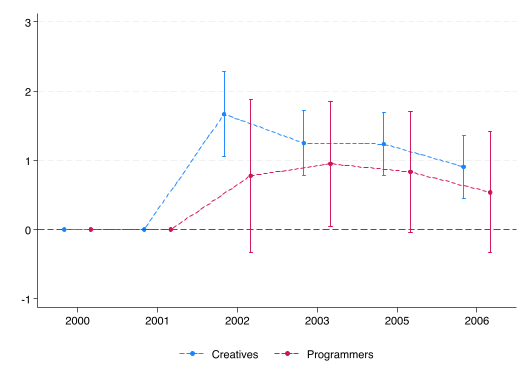

In [21]:
*# Define Variables #*
local FEs "pub_corp developer GenderID EthnicityID"
local Controls " JobN logRevenue ProjectSize Ptfm_* i.release_year MiddlewareExp"
local Min "2000"
local Max "2006"
local time_window "release_year >= 2000 & release_year <= 2005"
local Constraints "FinalPublisherRelease != 1 & FirstPublisherRelease != 1 & LastDeveloperRelease != 1 & (HID == 3| HID == 2) & (HID == HID_Previous) "

*# Regression Results for Creatives #* 
qui: reghdfe DevChange i.SHOOTER##i.PopMIDDLE##i.release_year `Controls' if `Constraints' & `time_window' & Role == "Creative", absorb(`FEs')
estimates store coefmodel1

*# Regression Results for Programmers #* 
qui: reghdfe DevChange i.SHOOTER##i.PopMIDDLE##i.release_year `Controls' if `Constraints' & `time_window' & Role == "Programmer", absorb(`FEs')
estimates store coefmodel2

*# Generate Coefficientplot #* 
coefplot (coefmodel1, label("Creatives")) ///
         (coefmodel2, label("Programmers")),  /// 
         keep(1.SHOOTER#1.PopMIDDLE#*) ///
            vertical yline(0, lcolor(red)) ciopts(recast(rcap)) ///
            omit base recast(connected) lpattern(--) ///
            legend(position(6) rows(1)) ///
            xlabel( 1 "2000" 2 "2001" 3 "2002" 4 "2003" 5 "2005" 6 "2006")

Here we re-estimate these coefficients reporting only the results for Any Middleware, not only popular middleware tools. 

In [22]:
*# Define Variables #*
local FEs "pub_corp developer GenderID EthnicityID"
local Controls " JobN logRevenue ProjectSize Ptfm_* i.release_year MiddlewareExp"
local Min "2000"
local Max "2006"
local time_window "release_year >= 2000 & release_year <= 2005"
local Constraints "FinalPublisherRelease != 1 & FirstPublisherRelease != 1 & LastDeveloperRelease != 1 & (HID == 3| HID == 2) & (HID == HID_Previous) "

*# Regression Results for Creatives #* 
qui: reghdfe DevChange i.SHOOTER##i.MIDDLE##i.release_year `Controls' if `Constraints' & `time_window' & Role == "Creative", absorb(`FEs')
estimates store coefmodel1

*# Regression Results for Programmers #* 
qui: reghdfe DevChange i.SHOOTER##i.MIDDLE##i.release_year `Controls' if `Constraints' & `time_window' & Role == "Programmer", absorb(`FEs')
estimates store coefmodel2

*# Generate Coefficientplot #* 
coefplot (coefmodel1, label("Creatives")) ///
         (coefmodel2, label("Programmers")),  /// 
         keep(1.SHOOTER#1.PopMIDDLE#*) ///
            vertical yline(0, lcolor(red)) ciopts(recast(rcap)) ///
            omit base recast(connected) lpattern(--) ///
            legend(position(6) rows(1)) ///
            xlabel( 1 "2000" 2 "2001" 3 "2002" 4 "2003" 5 "2005" 6 "2006")

(coefmodel1: no coefficients found, all dropped, or none kept)
(coefmodel2: no coefficients found, all dropped, or none kept)
(nothing to plot)


### 4.2. Baseline Trends for Mobility Patterns between Programmers and Creatives

---

Here we report the baseline probability of moving between companies on successing projects for programmers and creatives within our sample.


Variables that uniquely identify margins: Creative release_year


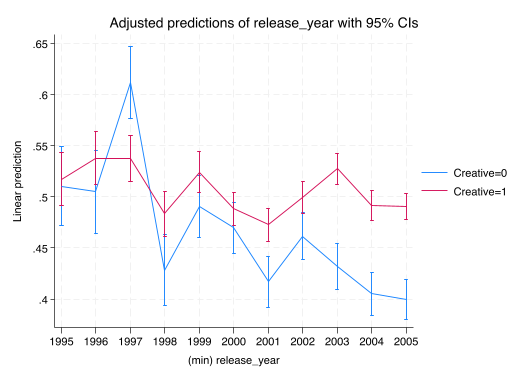

In [23]:
*# Define Variables in Macros #*
local FEs " developer GenderID EthnicityID "
local Controls "i.Creative JobN logRevenue ProjectSize Ptfm_*  MiddlewareExp "
local time_window " release_year >= 1995 & release_year <= 2005"
local Constraints "FinalPublisherRelease != 1 & FirstPublisherRelease != 1 & LastDeveloperRelease != 1 & (HID == 3| HID == 2) & (HID == HID_Previous)"

*# Split Sample for Programmers and Creatives #*
qui: reghdfe DevChange i.Creative##b2002.release_year if `Constraints' & `time_window'  , absorb(`FEs')
qui: margins release_year, at(Creative = (0 1))
marginsplot, recast(line) plotopts(mcolor(none)) xdimension(release_year)

## 5. Generate Final Output / Regression Tables 

In [24]:
*# Baseline Results #*

#delimit; 
esttab R_BL_3 R_BL_5a R_BL_5b R_HLC_b R_HLP_a using "./Figures & Tables/Table 1.html", replace html 
noomitted nobase 
b(%4.3f) se(%4.3f) 
scalars(r2 F p )
varwidth(35)
mtitles("Full Sample" "Creatives" "Programmers" "HL-Creatives" "LL-Programmers")
indicate("Project Size and Sales = logRevenue ProjectSize" 
         "Year FE = *release_year " 
         "Ptfm FE = *Ptfm*"
         "Experience Controls = MiddlewareExp JobN", labels("Y" ""));
#delimit cr

#delimit;
esttab R_Pop_Post_* using "./Figures & Tables/Table 2.html", replace html 
noomitted nobase 
b(%4.3f) se(%4.3f) 
scalars(r2 F p )
varwidth(35)
mtitles("Full Sample" "Creatives" "Programmers" "Full Sample")
indicate("Project Size and Sales = logRevenue ProjectSize" 
         "Year FE = *release_year " 
         "Ptfm FE = *Ptfm*"
         "Experience Controls = MiddlewareExp JobN", labels("Y" ""));
#delimit cr 

#delimit; 

esttab R_NMiddle_1 R_NMiddle_2 R_NMiddle_3 R_NMiddle_2P R_NMiddle_21P  R_NMiddle_3P  R_NMiddle_31P using "./Figures & Tables/Table 3.html", replace html 
noomitted nobase 
b(%4.3f) se(%4.3f) 
scalars(r2 F p )
varwidth(35)
mtitles("Full Sample" "Creatives" "Programmers" "Creatives" "Creatives From Middleware" "Programmers" "Programmers from Middleware" )
indicate("Project Size and Sales = logRevenue ProjectSize" 
         "Year FE = *release_year " 
         "Ptfm FE = *Ptfm*"
         "Experience Controls = MiddlewareExp JobN", labels("Y" ""));
#delimit cr 

(file ./Figures & Tables/Table 1.html not found)
(output written to ./Figures & Tables/Table 1.html)
(file ./Figures & Tables/Table 2.html not found)
(output written to ./Figures & Tables/Table 2.html)
(file ./Figures & Tables/Table 3.html not found)
(output written to ./Figures & Tables/Table 3.html)
